<a href="https://colab.research.google.com/github/NoorFatimaMemon/DeepLearning/blob/main/28_NLP_Basics_and_Embeddings/28_Word_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Word embeddings**

**What are Word Embeddings?**
* Computers don’t understand words, only numbers.
* One-hot encoding or assigning random numbers to words is not enough, because they don’t capture meaning.
* Embeddings are special vectors of numbers (learned automatically) that capture word relationships.
* Example:
  * "king" and "queen" end up having similar embeddings.
  * Words like "spam" and "advertisement" end up close together if trained on spam messages.
* In short: Embeddings = word meaning stored as numbers.

Text Classification with Word Embeddings (Pipeline)      


                  ┌─────────────────────┐
                  │   Raw Text Message   │
                  │  ("Free prize now!") │
                  └──────────┬──────────┘
                             │
                             ▼
           ┌────────────────────────────────┐
           │   TextVectorization Layer       │
           │  - lowercase                    │
           │  - remove punctuation           │
           │  - split into words             │
           │  - convert words → integers     │
           └──────────┬─────────────────────┘
                      │
                      ▼
       Example Output: [42, 178, 901, 57, 0, 0, ...]
       (fixed length sequence of numbers)

                      │
                      ▼
           ┌────────────────────────────────┐
           │   Embedding Layer               │
           │  Each number → vector of floats │
           │  (learned meaning of the word)  │
           └──────────┬─────────────────────┘
                      │
                      ▼
       Example Output: [[0.2, -0.1, 0.7, ...],
                        [-0.3, 0.9, 0.0, ...],
                        [0.1, 0.4, -0.2, ...], ...]

                      │
                      ▼
           ┌────────────────────────────────┐
           │ GlobalAveragePooling1D          │
           │ - Averages all word embeddings  │
           │   → creates one vector per SMS  │
           └──────────┬─────────────────────┘
                      │
                      ▼
       Example Output: [0.05, 0.22, -0.11, 0.33, ...]

                      │
                      ▼
           ┌────────────────────────────────┐
           │ Dense Layer (hidden neurons)    │
           │ - Learns patterns in messages   │
           └──────────┬─────────────────────┘
                      │
                      ▼
           ┌────────────────────────────────┐
           │ Dense Output Layer              │
           │ - Single value (logit)          │
           │ - Predicts Spam (1) or Ham (0)  │
           └────────────────────────────────┘

## **Import Libraries**

In [332]:
import os, io, re, string, shutil
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import numpy as np

## **Download and prepare dataset**
* We use the SMS Spam Collection Dataset (from UCI).
* It has short text messages labeled as:
  * ham = not spam
  * spam = junk message

In [333]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip"
path_to_zip = tf.keras.utils.get_file("smsspam.zip", origin=url, extract=True)
path_to_zip

'/root/.keras/datasets/smsspam_extracted'

In [334]:
data_file = os.path.join(path_to_zip, "SMSSpamCollection")
data_file

'/root/.keras/datasets/smsspam_extracted/SMSSpamCollection'

In [335]:
base_dir = "sms_data"
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.makedirs(base_dir + "/train/spam")
os.makedirs(base_dir + "/train/ham")

In [336]:
# Write SMS messages into txt files (for keras dataset loader)
with open(data_file, "r", encoding="utf-8") as f:
    lines = f.readlines()

for i, line in enumerate(lines):
    parts = line.strip().split("\t", 1)
    if len(parts) != 2:
        continue
    label, text = parts
    folder = "spam" if label == "spam" else "ham"
    with open(f"{base_dir}/train/{folder}/{i}.txt", "w", encoding="utf-8") as out:
        out.write(text)

In [337]:
# CHECK FILE COUNTS
print("Ham samples:", len(os.listdir(base_dir + "/train/ham")))
print("Spam samples:", len(os.listdir(base_dir + "/train/spam")))

Ham samples: 4827
Spam samples: 747


## **Create Training and Validation Sets**
* training = 80% of data → for learning.
* validation = 20% → for testing performance.
* Labels are created automatically from folder names (spam or ham)

In [338]:
batch_size = 512
seed = 42

train_ds = tf.keras.preprocessing.text_dataset_from_directory(base_dir + "/train", batch_size=batch_size, validation_split=0.2,
                                                              subset="training", seed=seed)
val_ds = tf.keras.preprocessing.text_dataset_from_directory(base_dir + "/train", batch_size=batch_size, validation_split=0.2,
                                                            subset="validation", seed=seed)

Found 5574 files belonging to 2 classes.
Using 4460 files for training.
Found 5574 files belonging to 2 classes.
Using 1114 files for validation.


In [339]:
for text, label in train_ds.take(3):
    print(text.numpy()[0][:50], label.numpy())

b'You are guaranteed the latest Nokia Phone, a 40GB ' [1 1 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## **Cache for speed**

In [340]:
# This makes reading and training faster (important for large data).
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
AUTOTUNE

-1

## **Text preprocessing**


In [341]:
def custom_standardization(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    cleaned = tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')
    return cleaned

In [342]:
# vectorize (convert words to numbers)
vocab_size, sequence_length = 10000, 100
vectorize_layer = layers.TextVectorization(standardize=custom_standardization, max_tokens=vocab_size,
                                           output_mode="int", output_sequence_length=sequence_length)

*   Keeps the 10,000 most common words.
*   Pads/cuts messages to length 100 words

In [343]:
# Adapt on training dataset
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

## **Build the Model**
Think of it like this:

Text  →  Vectorize  →  Embedding  →  Pooling  →  Dense Layers  →  Output

In [344]:
embedding_dim = 64
model = tf.keras.Sequential([vectorize_layer,   # Step 1: text → numbers
                             layers.Embedding(vocab_size, embedding_dim),  # Step 2: numbers → embeddings
                             # layers.GlobalAveragePooling1D(),  # Step 3: average embeddings
                             layers.Bidirectional(layers.LSTM(64)),
                             layers.Dense(64, activation="relu"),  # Step 4: hidden layer
                             layers.Dense(1, activation="sigmoid")  # Step 5: output (spam or ham)
                             ])

model.build(input_shape=(None,))
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_17           │ (None, 100)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_17 (Embedding)        │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 714,369 (2.73 MB)

 Trainable params: 714,369 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

In [345]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0)
#optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5, clipvalue=1.0)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer=optimizer,metrics=["accuracy"])

## **Train the Model**

In [346]:
# Extract labels from the dataset
all_labels = []
for _, labels in train_ds.unbatch():
    all_labels.append(labels.numpy())
all_labels = np.array(all_labels)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(0.5753353973168215), 1: np.float64(3.8184931506849313)}


In [347]:
callbacks = [tf.keras.callbacks.TensorBoard(log_dir="logs")]
history = model.fit(train_ds, validation_data=val_ds, epochs=150, class_weight=class_weights, callbacks=callbacks)

Epoch 1/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.8678 - loss: 0.6698 - val_accuracy: 0.8851 - val_loss: 0.6102
Epoch 2/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.9036 - loss: 0.5521 - val_accuracy: 0.8052 - val_loss: 0.3815
Epoch 3/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8461 - loss: 0.3251 - val_accuracy: 0.9390 - val_loss: 0.1622
Epoch 4/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9570 - loss: 0.1700 - val_accuracy: 0.9803 - val_loss: 0.0881
Epoch 5/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9864 - loss: 0.0863 - val_accuracy: 0.9838 - val_loss: 0.0628
Epoch 6/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9917 - loss: 0.0580 - val_accuracy: 0.9677 - val_loss: 0.0889
Epoch 7/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9949 - loss: 0.0419 - val_accuracy: 0.9605 - val_loss: 0.1046
Epoch 8/150
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9906 - loss: 0.0294 - val_accuracy: 0.9838 - val_loss

## **Evaluate the model**

In [348]:
loss, acc = model.evaluate(val_ds)
print(f"\nValidation Loss: {loss:.4f}")
print(f"Validation Accuracy: {acc:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9826 - loss: 0.1596

Validation Loss: 0.1491
Validation Accuracy: 0.9838


## **Plot accuracy & loss curves**

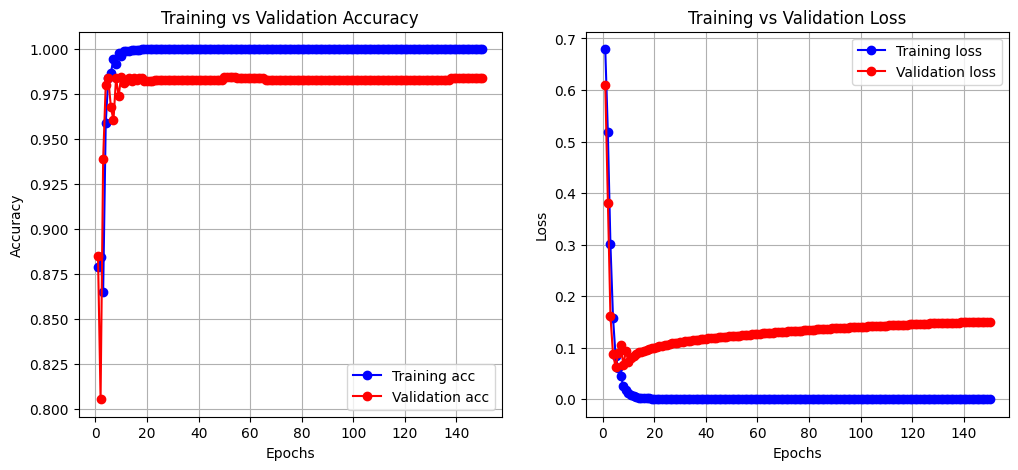

In [349]:
history_dict = history.history
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs = range(1, len(acc) + 1)

# Plot training history
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, "bo-", label="Training acc")
plt.plot(epochs, val_acc, "ro-", label="Validation acc")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(epochs, loss, "bo-", label="Training loss")
plt.plot(epochs, val_loss, "ro-", label="Validation loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.show()

## **Save Embeddings for Visualization**
The embeddings are stored inside the Embedding layer. We can extract them and save them in two files:

*   vectors.tsv → the actual numbers
*   metadata.tsv → the words

In [350]:
# Get the first Embedding layer by type
embedding_layer = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Embedding)][0]
weights = embedding_layer.get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    if index == 0:
        continue
    vec = weights[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")

out_v.close()
out_m.close()

## **Test on custom messages**

In [351]:
examples = ["Congratulations! You have won a $1000 Walmart gift card. Call now!",
            "Hey, are we still meeting for lunch today?",
            "Free entry in a weekly competition to win tickets!",
            "Ok bro, call me when you reach.",
            "URGENT! Your mobile number has won 2,000,000 pounds!"]

# Convert list of strings → tf.constant
example_tensor = tf.constant(examples)
predictions = model.predict(example_tensor)
for msg, pred in zip(examples, predictions):
    label = "SPAM" if pred[0] > 0.5 else "HAM"
    print(f"{msg} --> {label} ({pred[0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Congratulations! You have won a $1000 Walmart gift card. Call now! --> SPAM (1.0000)
Hey, are we still meeting for lunch today? --> HAM (0.0000)
Free entry in a weekly competition to win tickets! --> SPAM (1.0000)
Ok bro, call me when you reach. --> HAM (0.0000)
URGENT! Your mobile number has won 2,000,000 pounds! --> SPAM (1.0000)
